In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import uproot
import awkward as ak
# !pip install "uproot[http]"
# !pip install awkward-pandas

In [2]:
filepath = "tests/run_025034_cosmics.root"
file = uproot.open(filepath)
print(type(file))
file.keys()


<class 'uproot.reading.ReadOnlyDirectory'>


['PNSCRPanalyzercosmics;1',
 'PNSCRPanalyzercosmics/Event;58',
 'PNSCRPanalyzercosmics/Event;57']

In [8]:

evts = uproot.open(f"{filepath}:PNSCRPanalyzercosmics/Event") #library='pd'
# evts.show()


In [9]:
cols = evts.keys()
akw = evts.arrays(filter_name=evts.keys(), library="ak")
print(len(akw['event']))
akw

1544


<Array [{event: 1, evttime: ..., ...}, ...] type='1544 * {event: int32, evt...'>

## Waveforms

In [ ]:
Nevents    = len(akw['waveformsADC'])
TrigWindow = len(akw['waveformsADC'][0][0])
Nchannels  = len(akw['waveformsADC'][0])
print('events', Nevents)
print('trigger window', TrigWindow)
print('waveforms per event', len(akw['waveformsADC'][0]))

events 1544
trigger window 65600
waveforms per event 12


Text(0, 0.5, 'waveformsADC')

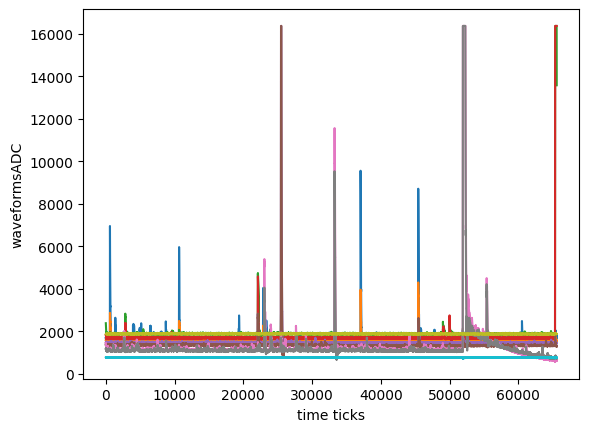

In [18]:
evtID = 0
x = np.arange(0,  TrigWindow, 1)
y = 'waveformsADC'

# issues: 7, 10 (membranes?)

# for chID in range(0, 12):
for chID in [0, 1, 2, 3, 4, 5, 6, 8, 9, 11]:
    plt.plot(x, akw[y][evtID][chID].to_numpy());

plt.xlabel('time ticks')
plt.ylabel(y)
# plt.xlim(0, 10000)
# plt.ylim(0, 1000)

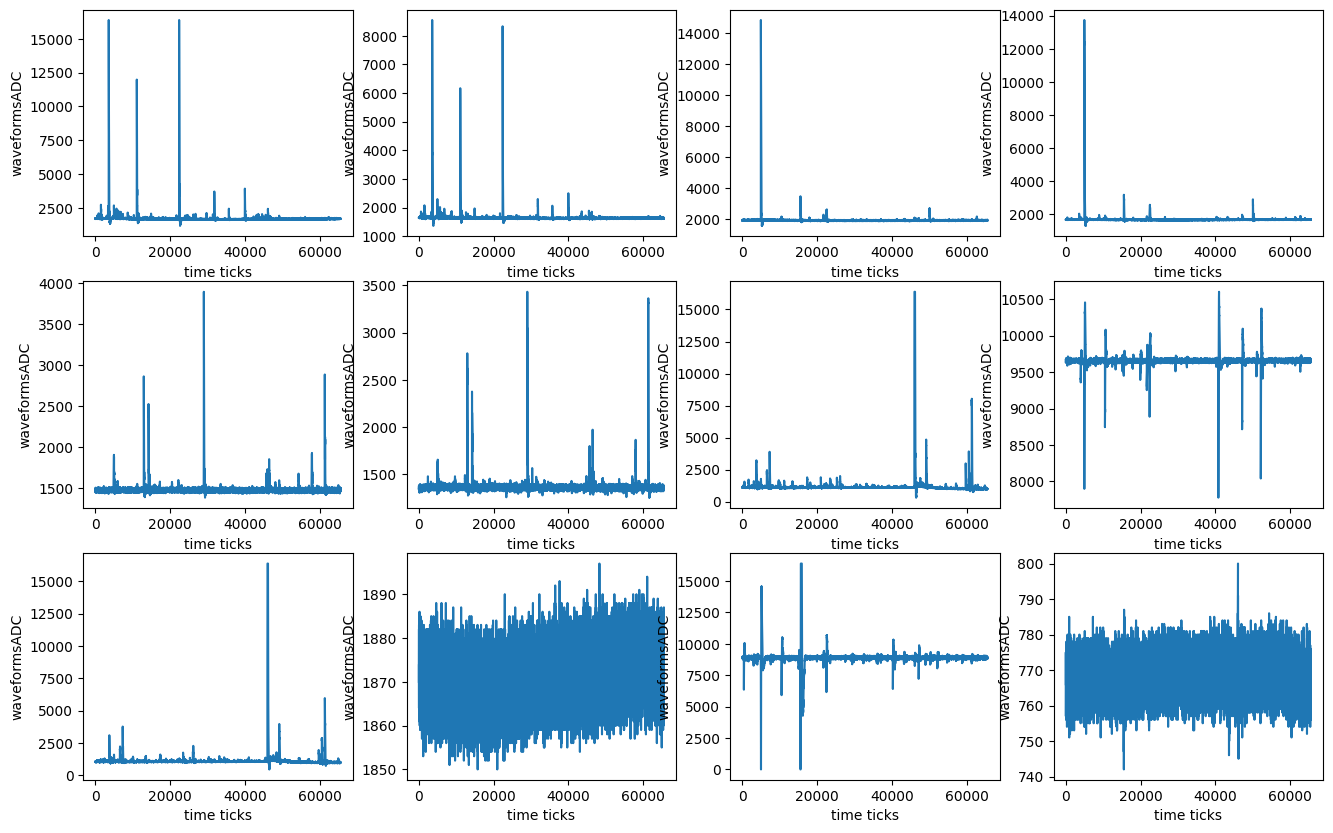

In [23]:
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

evtID = 100
x = np.arange(0,TrigWindow, 1)
y = 'waveformsADC'

a = 0
for chID in range(0, Nchannels):
    ax = axs.flatten()[a]
    ax.plot(x, akw[y][evtID][chID].to_numpy());
    a+=1
    ax.set_xlabel('time ticks')
    ax.set_ylabel(y)

